In [1]:
from typing import Dict, List, Tuple, Any, Annotated, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, AnyMessage
from langchain_core.tools import BaseTool
from langgraph.graph import START, StateGraph, END
from langchain_core.agents import AgentAction, AgentFinish
from langchain_openai import ChatOpenAI
import operator
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import create_react_agent
from langchain_core.runnables.graph import CurveStyle

from langgraph.types import Command
from typing_extensions import Literal

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

from IPython.display import Image, display
import os

from dotenv import load_dotenv
load_dotenv()

openai_api = os.getenv("OPENAI_API_KEY")
if openai_api is None:
    raise ValueError("Please set the OPENAI_API_KEY environment variable")
os.environ["OPENAI_API_KEY"] = openai_api

In [4]:
# tools

def file_read(file_dir: str) -> str:
    """
    Read file from a directory 

    Args:
        file_dir: directory of file to be read        
    """

    file_path = file_dir
    
    try:
        with open(file_path, "r") as file:
            return file.read()
    except FileNotFoundError:
        return f"Error: File not found at path: {file_path}"
    except PermissionError:
        return f"Error: Permission denied when trying to read file: {file_path}"
    except Exception as e:
        return f"Error: Failed to read file {file_path}. {str(e)}"
    
def email_sender(email_address: str, email_text: str) -> str:
    """
    Send email to a given email address

    Args:
        email_address: email address to send email to
        email_text: text of the email to be sent
    """ 

    # Dummy tool, just return a success message

    return f"Successfully sending email to {email_address}..."


In [26]:
# Agents
llm = ChatOpenAI(model="gpt-4o-mini")

tools = [file_read]
llm_with_tools = llm.bind_tools(tools)

recruitment_analyst_agent = create_react_agent(
    llm,
    tools=[file_read],
    prompt=(
        "You're a recruitment expert with 10 years of experience in the tech hiring field."
        "You're known for your ability to analyze tech job market trends, finding out relevant skills and experience in the tech"
        "and has a track record of success in finding the right candidates for the right jobs in the tech industry."
        "Your usual tasks are to analyze job market trends and candidate profiles to undertake recruitment strategy,"
        "conduct candidate analysis, job analysis, building a set of fitting candidate criteria for job description,"
        "conduct a candidate fit analysis, and provide a report on the candidate and job fit."
    ),
)

job_profiler_agent = create_react_agent(
    llm,
    tools=[file_read],
    prompt=(
        "You're a tech industry hiring expert with 10 years of experience in the tech hiring field, specializing in formulate candidate requirements profile."
        "You are known for your ability to create detailed job profiles for a strong candidate, from"
        "job descriptions and job analysis."
        "Your usual tasks are to create detailed job profiles for a candidate requirement from a job description and job opening analysis,"
        "and build a set of metrics to measure the candidate's fit for the job, organization, and culture."
    ),
)

hiring_candidate_evaluator_agent = create_react_agent(
    llm,
    tools=[],
    prompt=(
        "You're a tech industry hiring expert with 10 years of experience in the tech hiring field, specializing in candidate evaluation."
        "You have the experience of understanding the fitness of a candidate for tech industry."
        "You have extended experience in understanding organization and people needs in the tech industry for a strong hiring decision."
        "Your usual tasks are to evaluate candidate profiles against job profiles and provide a report on the candidate's fit for the job, organization, and culture."
    ),
)

tech_company_communication_department_agent = create_react_agent(
    llm,
    tools=[email_sender],
    prompt=(
        "You're an experienced communication specialist in tech industry with a strong communication and interpersonal skills."
        "You have a deep understanding of the tech industry and the needs of the tech companies."
        "Your usual tasks are to Communicate and liaise with any internal or external stakeholders for a tech company."
        "You can write and revise communication emails for a tech company."
        "And authorized to send emails on behalf of the tech company to internal or external stakeholders."
    ),
)

In [27]:
# Tasks Prompts

cv_analysis_task_prompt = """current task description: >
    Analyze the candidate's CV on its own, without any context of the job description or job opening.
    Make sure you find any interesting and relevant information given the current year is {current_year}.
    Identify the candidate's skills, experience, strength, weaknesses, and any other relevant information.
    CV file: {path_to_cv}
  expected_output: >
    A structured report with sections for 
    1. summary of the candidate
    2. candidate's skills
    3. experience
    4. strength
    5. weaknesses
    6. other relevant information both good or bad information (if any)"""

job_description_analysis_task_prompt = """current task description: >
    Analyze the job description and job opening.
    Make sure you find any interesting and relevant information.
    You are very confident about your ability, only use websearch when you need INFORMATION (NOT GUIDANCE) about the organization, the technology or terminology in the job description.    

    Identify the job's requirements: skills, experience, education background, education level, other relevant requirements.  
    Job desc file: {path_to_job_desc}
  expected_output: >
    A structured report with sections for 
    1. detailed summary of the job
    2. description of required skills
    3. description of required experience level
    4. description of required education background and level
    6. other relevant requirement (if any)"""

job_profile_creation_task_prompt = """current task description: >
    Create a job profile for the job description and job opening.
    You are very confident about your ability, only use websearch when you need INFORMATION (NOT GUIDANCE) about the organization, the technology or terminology in the job description.    

    Job desc file: {path_to_job_desc}
  expected_output: >
    A detailed job profile describing a strong candidate for the job."""

recruitment_scoring_builder_prompt = """current task description: >
    Build relevant scoring criteria for the job description and job profile, to be used to evaluate candidates for the job.
    Build the scoring criteria based on the job profile and job description file.

    Job desc file: {path_to_job_desc}

  expected_output: >
    A scoring criteria for the job description and job profile."""

candidate_fitness_analysis_task_prompt = """current task description: >
    Analyse candidate fitness from CV analysis, job description analysis, and job profile.
    More information can be extracted from the CV and job description.
    You are very confident about your ability, only use websearch when you need INFORMATION (NOT GUIDANCE) about the organization, the technology or terminology in the job description.    

    CV file: {path_to_cv}    
    Job desc file: {path_to_job_desc}

  expected_output: >
    A detailed analysis of the candidate's fitness for the job."""

candidate_fitness_scoring_and_decision_task_prompt = """current task description: >
    Score the candidate's fitness for the job based on the scoring criteria and candidate fitness analysis.
    More information can be extracted from the CV, job description.

    You do not need and will not be allowed to use websearch for this task.
    Make a decision whether the candidate is a fit for the job or not.

    CV file: {path_to_cv}    
    Job desc file: {path_to_job_desc}

  expected_output: >
    A score for the candidate's fitness for the job.
    A decision whether the candidate is a fit for the job or not, and to move to the next step or not."""

candidate_email_communication_task_prompt = """current task description: >
    Write a follow up email for the hiring process, whether the candidate is a fit or not.
    Then send an email to the candidate to inform them about the next steps in the hiring process.
    Email address should be in the CV.

    CV file: {path_to_cv}    
    Job desc file: {path_to_job_desc}

  expected_output: >
    A confirmation email to the candidate.
    If a candidate is a fit, send them an email to schedule an interview.
    If a candidate is not a fit, send them an email to thank them for their time and effort."""


In [81]:
# -> Command[Literal["cv_analysis_task", "__end__"]]
# Tasks
def cv_analysis_task(state: MessagesState) :
    
    formatted_prompt = cv_analysis_task_prompt.format(
        current_year=2025,
        path_to_cv="../data/cv1.md"
    )
    
    # pass only relevant messages to the agent
    # response = recruitment_analyst_agent.invoke(
    #     {"messages" : messages}
    # )
    
    # return {"messages": response['messages']}

    # pass the full messages state to the agent
    state["messages"].append(HumanMessage(content=formatted_prompt))    
    return recruitment_analyst_agent.invoke(state)

# -> Command[Literal["job_description_analysis_task", "__end__"]]

def job_description_analysis_task(state: MessagesState) :
    
    formatted_prompt = job_description_analysis_task_prompt.format(        
        path_to_job_desc="../data/job1.md"
    )
    # messages = [HumanMessage(content=formatted_prompt)]
    # response = job_profiler_agent.invoke({"messages" : messages})

    # return {"messages": response['messages']}

    state["messages"].append(HumanMessage(content=formatted_prompt))    
    return recruitment_analyst_agent.invoke(state)

# -> Command[Literal["job_profile_creation_task", "__end__"]]

def job_profile_creation_task(state: MessagesState) :
    formatted_prompt = job_profile_creation_task_prompt.format(        
        path_to_job_desc="../data/job1.md"
    )
    # messages = [HumanMessage(content=formatted_prompt)]
    # response = job_profiler_agent.invoke({"messages" : messages})

    # return {"messages": response['messages']}

    state["messages"].append(HumanMessage(content=formatted_prompt))    
    return job_profiler_agent.invoke(state)

builder = StateGraph(MessagesState)

builder.add_node("cv_analysis_task", cv_analysis_task)
builder.add_node("job_description_analysis_task", job_description_analysis_task)
builder.add_node("job_profile_creation_task", job_profile_creation_task)

builder.add_edge(START, "cv_analysis_task")
builder.add_edge("cv_analysis_task", "job_description_analysis_task")
builder.add_edge("job_description_analysis_task", "job_profile_creation_task")
# builder.add_edge("job_profile_creation_task", END)

graph = builder.compile()

^^^ need to find a way to invoke the path and year dynamically outside the graph building

In [83]:
graph.get_graph().print_ascii()

          +-----------+            
          | __start__ |            
          +-----------+            
                *                  
                *                  
                *                  
      +------------------+         
      | cv_analysis_task |         
      +------------------+         
                *                  
                *                  
                *                  
+-------------------------------+  
| job_description_analysis_task |  
+-------------------------------+  
                *                  
                *                  
                *                  
  +---------------------------+    
  | job_profile_creation_task |    
  +---------------------------+    


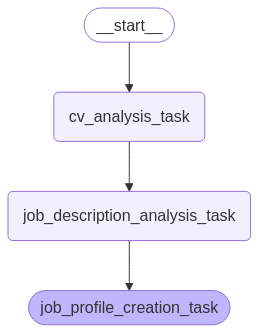

In [82]:
from langchain_core.runnables.graph import CurveStyle
display(Image(graph.get_graph().draw_mermaid_png(curve_style = CurveStyle.BASIS )))

In [84]:
messages = [HumanMessage(content="Do your tasks")]
messages = graph.invoke({"messages": messages})   

In [85]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Do your tasks
================================ Human Message =================================

current task description: >
    Analyze the candidate's CV on its own, without any context of the job description or job opening.
    Make sure you find any interesting and relevant information given the current year is 2025.
    Identify the candidate's skills, experience, strength, weaknesses, and any other relevant information.
    CV file: ../data/cv1.md
  expected_output: >
    A structured report with sections for 
    1. summary of the candidate
    2. candidate's skills
    3. experience
    4. strength
    5. weaknesses
    6. other relevant information both good or bad information (if any)
================================== Ai Message ==================================
Tool Calls:
  file_read (call_ipu7QSs954R1z63iYYtHAvnY)
 Call ID: call_ipu7QSs954R1z63iYYtHAvnY
  Args:
    file_dir: ../data/cv1.md
=

## Travel Agent example from Langchain web

In [69]:
import random
from typing_extensions import Literal


@tool
def get_travel_recommendations():
    """Get recommendation for travel destinations"""
    return random.choice(["aruba", "turks and caicos"])


@tool
def get_hotel_recommendations(location: Literal["aruba", "turks and caicos"]):
    """Get hotel recommendations for a given destination."""
    return {
        "aruba": [
            "The Ritz-Carlton, Aruba (Palm Beach)"
            "Bucuti & Tara Beach Resort (Eagle Beach)"
        ],
        "turks and caicos": ["Grace Bay Club", "COMO Parrot Cay"],
    }[location]

In [71]:
from typing import Annotated

from langchain_core.tools import tool
from langchain_core.tools.base import InjectedToolCallId
from langgraph.prebuilt import InjectedState


def make_handoff_tool(*, agent_name: str):
    """Create a tool that can return handoff via a Command"""
    tool_name = f"transfer_to_{agent_name}"

    @tool(tool_name)
    def handoff_to_agent(
        state: Annotated[dict, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Ask another agent for help."""
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": tool_name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            # navigate to another agent node in the PARENT graph
            goto=agent_name,
            graph=Command.PARENT,
            # This is the state update that the agent `agent_name` will see when it is invoked.
            # We're passing agent's FULL internal message history AND adding a tool message to make sure
            # the resulting chat history is valid.
            update={"messages": state["messages"] + [tool_message]},
        )

    return handoff_to_agent

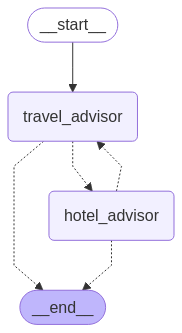

In [72]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command


model = ChatOpenAI(model="gpt-4o-mini")

# Define travel advisor ReAct agent
travel_advisor_tools = [
    get_travel_recommendations,
    make_handoff_tool(agent_name="hotel_advisor"),
]
travel_advisor = create_react_agent(
    model,
    travel_advisor_tools,
    prompt=(
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help. "
        "You MUST include human-readable response before transferring to another agent."
    ),
)


def call_travel_advisor(
    state: MessagesState,
) -> Command[Literal["hotel_advisor", "__end__"]]:
    # You can also add additional logic like changing the input to the agent / output from the agent, etc.
    # NOTE: we're invoking the ReAct agent with the full history of messages in the state
    return travel_advisor.invoke(state)


# Define hotel advisor ReAct agent
hotel_advisor_tools = [
    get_hotel_recommendations,
    make_handoff_tool(agent_name="travel_advisor"),
]
hotel_advisor = create_react_agent(
    model,
    hotel_advisor_tools,
    prompt=(
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
        "You MUST include human-readable response before transferring to another agent."
    ),
)


def call_hotel_advisor(
    state: MessagesState,
) -> Command[Literal["travel_advisor", "__end__"]]:
    return hotel_advisor.invoke(state)


builder = StateGraph(MessagesState)
builder.add_node("travel_advisor", call_travel_advisor)
builder.add_node("hotel_advisor", call_hotel_advisor)
# we'll always start with a general travel advisor
builder.add_edge(START, "travel_advisor")

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))